## Rationale for the visualisation

* generate bins of size 50 from 1 to 1,000
* the *Aeneid* contains 12 books (see dictionary below for consistency)
* create a matrix of 12 rows x 20 columns (dict of dicts)
    * initialise the value of each bin to 0 or None (if the bin scope falls outside the number of lines in the book)
* iterate through the results of the API and increment the count

1. generate empty matrix
2. get and store JSTOR MatchMaker data (quotations)
3. get and store CREX data (references)
4. iterate through quotations and update matrix
5. iterate through references and update matrix
6. output data in a d3.js-friendly JSON format

In [1]:
import matplotlib; matplotlib.use('Agg')
%matplotlib inline
import ConfigParser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import json
import requests
import seaborn as sns;sns.set()
import codecs
from MyCapytain.common.reference import URN

In [2]:
def create_matrix():
    """
    TODO.
    """
    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in xrange(0, len(l), n):
            yield l[i:i+n]
    # the number of lines for each book in the Aeneid
    # keys are book numbers, values are numbers of lines
    book_upper_boundaries = {
        1:756
        ,2:804
        ,3:719
        ,4:705
        ,5:871
        ,6:901
        ,7:817
        ,8:731
        ,9:818
        ,10:908
        ,11:915
        ,12:952
    }
    quotation_freq_matrix = {}
    chunks = {(chunk[0],chunk[-1]):chunk for chunk in list(chunks(range(1,1001),50))}
    for book_number in sorted(book_upper_boundaries.keys()):
        max_line_number = book_upper_boundaries[book_number]
        temp = {}
        for range_start,range_end in chunks.keys():
            if (range_start < max_line_number and range_end <= max_line_number):
                temp["%i-%i"%(range_start,range_end)] = {"reference_count":0,"quotation_count":0,"results":set()}
            elif(range_start < max_line_number and range_end > max_line_number):
                temp["%i-%i"%(range_start,range_end)] = {"reference_count":0,"quotation_count":0,"results":set()}
            else:
                temp["%i-%i"%(range_start,range_end)] = np.nan
        quotation_freq_matrix[book_number] = temp
        df = pd.DataFrame.from_dict(quotation_freq_matrix)
    return df.reindex_axis(sorted(df.index
                                ,key=lambda x: int(x.split('-')[0]))
                                 ,axis=0), chunks

In [3]:
def save_matrix_as_json(matrix, filepath):
    """
    Saves the matrix in a JSON and d3-friendly format.
    """
    import codecs
    import json
    try:
        data = json.loads(matrix.to_json(orient="split"))
        reshaped_data = [{"chunk":data["index"][i]
                  ,"book":data["columns"][j]
                  ,"counts":book} for i,chunk in enumerate(data["data"]) 
                                                             for j,book in enumerate(chunk)]
        json.dump(reshaped_data, codecs.open(filepath,"w","utf-8"))
        return True
    except Exception as e:
        print e
        return False

## Create an empty matrix data structure for the Aeneid

columns = books; rows = line chunks of size n=50

In [44]:
df,chunks = create_matrix()

In [5]:
#df.head()

In [30]:
save_matrix_as_json(df, "../data/test.json") # we let pandas serialize it as json, as it's very good at it

True

## Query the MatchMaker API

In [4]:
def get_aeneid_quotations_in_JSTOR(path_credentials="authentication.conf"):
    """
    TODO
    """
    matchmaker_endpoint = "http://labs.jstor.org/apis/matchmaker/"
    parameters = {'work':'virgil_aeneid','limit':50000}
    config = ConfigParser.ConfigParser(allow_no_value=True)
    config.read(path_credentials)
    credentials = (config.get("jstor","user"), config.get("jstor","pwd"))
    response = requests.get(matchmaker_endpoint
                            , params=parameters
                            , auth=credentials)
    data = response.json()
    for doc in data["docs"]:
        doc["chunk_urns"]  = [chunk_id.replace('<verg. aen. ','urn:cts:latinLit:phi0690.phi003:').replace('>','')
                                                                                   for chunk_id in doc["chunk_ids"]]
    return data

In [5]:
mm_data = get_aeneid_quotations_in_JSTOR()

JSONDecodeError: Expecting value: line 4 column 1 (char 3)

In [43]:
json.dump(mm_data,codecs.open("../data/matchmaker_api_output.json","w","utf-8"))

### Iterate over the data and update the quotation frequency count

In [4]:
from flask_restful import marshal, fields

Create a new empy matrix where to store the data and counts:

In [5]:
quotation_freq_df,chunks = create_matrix()

Load the data that were previously fetched via the API and stored into a file

In [6]:
data = json.load(codecs.open("../data/matchmaker_api_output.json","r","utf-8"))

In [7]:
#data["docs"][2]

Now define the fields for marshalling data into a new JSON structure

In [8]:
quotation_fields = {
    "document":{
        "doi": fields.String(attribute="docid")
        ,"year":fields.Raw(attribute="pubyear")
        ,"pubdate":fields.String
        ,"journaltitle":fields.String(attribute="journal")
        ,"author": fields.List(fields.String, attribute="authors")
        ,"title":fields.String
    }
    ,"id": fields.String
    ,"snippet":fields.String
    ,"all_urns":fields.List(fields.String, attribute="chunk_urns")
}

Transform the quotation records into an index: `quotation_id` => `quotation_record`

In [9]:
quotations = {doc["id"]: dict(marshal(doc,quotation_fields)) for doc in data["docs"]}

In [10]:
quoted_urns = [(urn,doc["id"]) for doc in data["docs"] for urn in doc["chunk_urns"]]

In [11]:
len(quoted_urns)

29941

In [12]:
#quoted_urns[:1]

Go trough all quotations and add each `quotation_id` to the chunk where it falls:

In [13]:
for urn, quotation_id in quoted_urns:
    quoted_urn = URN(urn)
    book_n, line_n = quoted_urn.reference.list
    book_n = int(book_n)
    line_n = int(line_n)
    for start_range,end_range in chunks:
        # find the chunk in which the line falls
        if (line_n >= start_range and line_n <= end_range):
            if(quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n] is not np.nan):
                quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n]["results"].add(('quotation'
                                                                                               , quotation_id))

In [14]:
#quotation_freq_df.loc["1-50"][1]["results"]

## Query the CitedLoci API

### Load the data about references to the Aeneid

In [15]:
my_data = json.load(codecs.open("../data/citedloci_api_output.json","r","utf-8"))

In [16]:
my_data["result"][0]

{u'document': {u'author': u'Nicholas Purcell',
  u'doi': u'10.2307/1562134',
  u'issue': u'3',
  u'journaltitle': u'The American Journal of Philology',
  u'pagerange': u'pp. 329-358',
  u'pubdate': u'Wed, 01 Oct 2003 00:00:00 -0000',
  u'publisher': u'The Johns Hopkins University Press',
  u'title': u'The Way We Used to Eat: Diet_ Community_ and History at Rome',
  u'url': u'http://www.jstor.org/stable/10.2307/1562134',
  u'volume': u'124'},
 u'id': u'571a3f2eb634c1c679ee8e38',
 u'line_number': 252,
 u'reference_type': u'scope',
 u'snippet': u'Another preoccupation of the De gente, which is inviting for the cultural historian, was what, and from which people, the Romans copied : "quid a quaque traxerint gente per imitationem" (fr. 21 Peter, Servius, ad <em>Aen.</em> <em>7.176).</em>',
 u'surface': u'Aen. 7.176).',
 u'urns': {u'author_urn': u'urn:cts:latinLit:phi0690',
  u'reference_urn': u'urn:cts:latinLit:phi0690.phi003:7.176',
  u'work_urn': u'urn:cts:latinLit:phi0690.phi003'}}

In [17]:
referenced_urns = [(doc["id"], doc["urns"]["reference_urn"]
                    ,URN(doc["urns"]["reference_urn"]).reference.list) for doc in my_data["result"]
                                                    if URN(doc["urns"]["reference_urn"]).reference.list is not None
                                                      and len(URN(doc["urns"]["reference_urn"]).reference.list)==2]

In [18]:
references = {doc["id"]:doc for doc in my_data["result"]
                                                    if URN(doc["urns"]["reference_urn"]).reference.list is not None
                                                      and len(URN(doc["urns"]["reference_urn"]).reference.list)==2}

In [19]:
len(referenced_urns)

12056

In [20]:
referenced_urns[:1]

[(u'571a3f2eb634c1c679ee8e38',
  u'urn:cts:latinLit:phi0690.phi003:7.176',
  [u'7', u'176'])]

### Add the references to the matrix

**TODO**: check what happens here to references that are a range

In [21]:
invalid_citations = []
for reference_id, urn, scope in referenced_urns:
    book_n, line_n = scope
    book_n = int(book_n)
    line_n = int(line_n)
    for start_range,end_range in chunks:
        # find the chunk in which the line falls
        if (line_n >= start_range and line_n <= end_range):
            try:
                if(quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n] is not np.nan):
                    quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n]["results"].add(("reference"
                                                                                                  , reference_id)) 
            except Exception as e:
                invalid_citations.append(urn[0])

In [22]:
len(references)

12056

In [23]:
len(invalid_citations)

556

### Count DOIs

In [24]:
len(quotations)

11228

In [25]:
len(references)

12056

In [26]:
references.keys()[0]

u'571a55b4b634c1c68aef5228'

In [27]:
doi_references = [references[result]["document"]["doi"] for result in references.keys()]

In [28]:
doi_quotations = [quotations[result]["document"]["doi"] for result in quotations.keys()]

In [29]:
len(set(doi_references))

3314

In [30]:
len(set(doi_quotations))

3027

In [31]:
len(set(doi_quotations).intersection(set(doi_references)))

554

### Fetching Metadata

In [32]:
def fetch_JSTOR_metadata(doi, path_credentials="authentication.conf"):
    """
    TODO
    """
    matchmaker_endpoint = "http://labs.jstor.org/api/metadata/%s"%doi
    #config = ConfigParser.ConfigParser(allow_no_value=True)
    #config.read(path_credentials)
    #credentials = (config.get("jstor","user"), config.get("jstor","pwd"))
    response = requests.get(matchmaker_endpoint
                            #, auth=credentials
                           )
    return response.json()

In [35]:
for reference in references.keys():
    document  = references[reference]["document"]
    #metadata = fetch_JSTOR_metadata(document["doi"])
    metadata = requests.get("http://labs.jstor.org/api/metadata/%s"%document["doi"]).json()
    if("year" in metadata):
        document["year"] = metadata["year"]
    if("authors" in metadata):
        document["author"] = ", ".join(metadata["authors"])

In [36]:
len(references)

12056

### Replace ids with references/annotations and update the counts

In [37]:
for chunk in quotation_freq_df.index:
    for book in quotation_freq_df.loc[chunk]:
        # if it's null means the line chunks actually don't exist 
        if book is not np.nan:
            # the duplicate are removed by counting the quotation ids
            # i.e. even if a quotation spans multiple lines, it is still counted once 
            refs = [(record_type, record_id) for record_type, record_id in book["results"] 
                                                                                   if record_type=="reference"]
            quots = [(record_type, record_id) for record_type, record_id in book["results"] 
                                                                                   if record_type=="quotation"]
            book["reference_count"] = len(refs)
            book["quotation_count"] = len(quots)
            book["results"]  = [references[record_id] for record_type, record_id in refs 
                                                                                   if record_type=="reference"]
            for record_type, record_id in quots:
                if record_type=="quotation":
                    quot = quotations[record_id]
                    quot["type"] = "quotation"
                    quot["document"]["url"] = "%s%s"%("http://www.jstor.org/stable/",quot["document"]["doi"])
                    book["results"].append(quot)

In [216]:
#quotation_freq_df.loc["1-50"][1]

## Now let's do the grouping of the results

In [38]:
from pyCTS import CTS_URN

In [39]:
def group_by_passage(results):
    index_of_passages = {}
    for result in results:
        if(not "type" in result or result["type"]=="reference"):
            result["type"] = "reference"
            urn = CTS_URN(result["urns"]["reference_urn"])
            scope = urn.passage_component
        elif(result["type"]=="quotation"):
            urn = CTS_URN(result["all_urns"][0])
            scope = urn.passage_component
        if scope in index_of_passages:
            index_of_passages[scope].append(result)
        else:
            index_of_passages[scope] = []
            index_of_passages[scope].append(result)
    return index_of_passages

In [40]:
def group_by_doi(results):
    by_doi = {r["document"]["doi"]:[] for r in results}
    for result in results:
        by_doi[result["document"]["doi"]].append(result)
    return by_doi

In [41]:
quotation_freq_df.tail(2)

,1,2,3,4,5,6,7,8,9,10,11,12
901-950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{u'reference_count': 1, u'quotation_count': 8,...","{u'reference_count': 2, u'quotation_count': 4,...","{u'reference_count': 25, u'quotation_count': 1..."
951-1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{u'reference_count': 9, u'quotation_count': 11..."


In [42]:
for rowid, row in list(quotation_freq_df.iterrows()):
    for i,value in enumerate(row):
        if(value is not np.nan):
            print rowid, row.index[i]
            results = group_by_passage(value["results"])
            groups = []
            start_chunk, end_chunk = [int(number) for number in rowid.split("-")]
            # this will need to be sorted first!
            for line in sorted(results.keys(),key=lambda x: int(x.split(".")[1])):
                print line
                line_number = int(line.split(".")[1])
                if(line_number >= start_chunk and line_number <= end_chunk):
                    group = {}
                    group["line"] = line
                    group["ref_count"] = sum([1 for result in results[line] if result["type"]=="reference"])
                    group["quot_count"] = sum([1 for result in results[line] if result["type"]=="quotation"])
                    group["label"] = "%s %s"%("Aen.",line)
                    group["results"] = results[line]
                    groups.append(group)
                else:
                    print "Line %s does not belong to %s:%s"%(line,rowid,row.index[i])
            quotation_freq_df.loc[rowid][row.index[i]]["results"] = groups

1-50 1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
1.10
1.11
1.12
1.13
1.14
1.15
1.16
1.17
1.18
1.19
1.20
1.21
1.22
1.23
1.24
1.25
1.26
1.27
1.28
1.29
1.30
1.31
1.32
1.33
1.34
1.35
1.36
1.37
1.38
1.39
1.40
1.41
1.42
1.43
1.44
1.045
1.45
1.46
1.47
1.48
1.49
1.50
1-50 2
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
2.10
2.11
2.12
2.13
2.14
2.15
2.16
2.17
2.18
2.19
2.20
2.21
2.22
2.23
2.24
2.25
2.26
2.27
2.28
2.29
2.30
2.31
2.32
2.34
2.35
2.36
2.37
2.38
2.39
2.40
2.41
2.42
2.43
2.44
2.45
2.46
2.47
2.48
2.49
2.50
1.748
Line 1.748 does not belong to 1-50:2
1.753
Line 1.753 does not belong to 1-50:2
1.755
Line 1.755 does not belong to 1-50:2
1.756
Line 1.756 does not belong to 1-50:2
1-50 3
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
3.10
3.11
3.12
3.13
3.14
3.15
3.16
3.17
3.18
3.19
3.20
3.21
3.22
3.23
3.24
3.25
3.26
3.27
3.28
3.29
3.30
3.31
3.33
3.34
3.35
3.36
3.37
3.38
3.39
3.40
3.41
3.44
3.45
3.46
3.47
3.48
3.49
3.50
1-50 4
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
4.10
4.11
4.12
4.13
4.14
4.15
4.16
4.17
4.18
4.19
4.20


In [43]:
save_matrix_as_json(quotation_freq_df, "../data/quot_freq.json")

True

In [33]:
quotation_freq_df.loc["1-50"][4]

{'quotation_count': 115,
 'reference_count': 194,
 'results': [{'label': u'Aen. 4.1',
   'line': u'4.1',
   'quot_count': 18,
   'ref_count': 16,
   'results': [{u'document': {u'author': u"James J. O'Hara",
      u'doi': u'10.2307/311293',
      u'issue': u'',
      u'journaltitle': u'Harvard Studies in Classical Philology',
      u'pagerange': u'pp. 335-342',
      u'pubdate': u'Mon, 01 Jan 1990 00:00:00 -0000',
      u'publisher': u'Department of the Classics_ Harvard University',
      u'title': u"The Significance of Vergil's Acidalia Mater_ and Venus Erycina in Catullus and Ovid",
      u'url': u'http://www.jstor.org/stable/10.2307/311293',
      u'volume': u'93'},
     u'id': u'571a54a5b634c1c6a2ef482c',
     u'line_number': 83,
     u'reference_type': u'scope',
     u'snippet': u'The resemblances already noted extend to the wound imagery : saucia cura at <em>Aen.</em> <em>4.1</em> is an adaptation of saucia curas at Cat. 64.250.',
     u'surface': u'Aen. 4.1',
     'type': 'refer

In [32]:
[x["label"] for x in quotation_freq_df.loc["1-50"][4]["results"]]

[u'Aen. 4.1',
 u'Aen. 4.2',
 u'Aen. 4.3',
 u'Aen. 4.4',
 u'Aen. 4.5',
 u'Aen. 4.6',
 u'Aen. 4.7',
 u'Aen. 4.8',
 u'Aen. 4.9',
 u'Aen. 4.10',
 u'Aen. 4.11',
 u'Aen. 4.12',
 u'Aen. 4.13',
 u'Aen. 4.14',
 u'Aen. 4.15',
 u'Aen. 4.16',
 u'Aen. 4.17',
 u'Aen. 4.18',
 u'Aen. 4.19',
 u'Aen. 4.20',
 u'Aen. 4.21',
 u'Aen. 4.22',
 u'Aen. 04.22',
 u'Aen. 4.23',
 u'Aen. 4.24',
 u'Aen. 4.25',
 u'Aen. 4.26',
 u'Aen. 4.27',
 u'Aen. 4.28',
 u'Aen. 4.29',
 u'Aen. 4.30',
 u'Aen. 4.31',
 u'Aen. 4.32',
 u'Aen. 4.33',
 u'Aen. 4.34',
 u'Aen. 4.35',
 u'Aen. 4.36',
 u'Aen. 4.37',
 u'Aen. 4.38',
 u'Aen. 4.39',
 u'Aen. 4.41',
 u'Aen. 4.44',
 u'Aen. 4.45',
 u'Aen. 4.46',
 u'Aen. 4.47',
 u'Aen. 4.50']

In [109]:
groups = group_by_passage(sample)

In [132]:
for group in groups:
    groups[group] = group_by_doi(groups[group])

In [ ]:
# TODO
# for each chunk
# group the results by line
# order the resulting dict by line
# group by doi
# order by doi chronologically (take year info from external dict)
# create labels for articles, counts etc.
[
    {
        "line":"1.1"
        ,"label":"Aen. 1.1"
        ,"reference_count":10
        ,"quotation_count":50
        "groups" = [
            {
             "label":"Carl P. E. Springer (2003)"
             ,"doi":"10.2307/30221884"
             ,"n_quotations":1
             ,"n_references":2
             ,"results" = [] 
            }
        ]
    }
]

## Plot

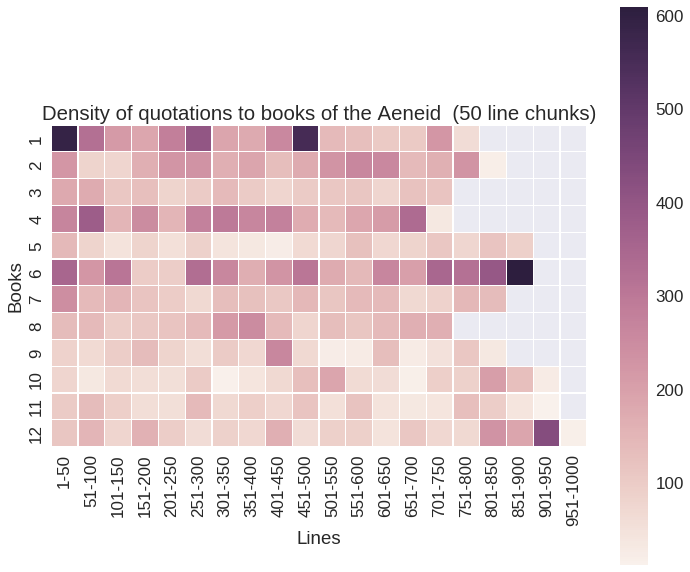

In [16]:
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(quotation_freq_df,square=True,linewidths=.2)
ax.set_title("Density of quotations to books of the Aeneid  (50 line chunks)")
ax.set_xlabel('Lines')
ax.set_ylabel('Books')

In [17]:
ax.figure.savefig('quotation_freq_heatmap.png')


## Get the Latin text of the Aeneid from Perseus

http://cts.perseids.org/api/cts/?request=GetPassagePlus&urn=urn:cts:latinLit:phi0690.phi003:1.1


or simply download this https://github.com/PerseusDL/canonical-latinLit/blob/master/data/phi0690/phi003/phi0690.phi003.perseus-lat2.xml

and parse it with BeautifoulSoup...

In [1]:
import urllib2
import bs4
from bs4 import BeautifulSoup

In [2]:
perseus_aeneid_latin = "https://raw.githubusercontent.com/PerseusDL/canonical-latinLit/master/data/phi0690/phi003/phi0690.phi003.perseus-lat2.xml"
soup = BeautifulSoup(urllib2.urlopen(perseus_aeneid_latin).read(),"xml")
divs = soup.find_all("div",subtype="book",type="textpart")

FeatureNotFound: Couldn't find a tree builder with the features you requested: xml. Do you need to install a parser library?

In [3]:
def create_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

chunks = {(bin[0],bin[-1]):bin for bin in list(create_chunks(range(1,1001),50))}

In [4]:
def find_chunk(line_number, chunks):
    for start_line, end_line in chunks:
        if(line_number >= start_line and line_number <= end_line):
            return start_line,end_line

In [ ]:
text = {}
for div in divs:
    text[div["n"]] = {"%i-%i"%(start_line,end_line):[] for start_line, end_line in chunks}

In [ ]:
for div in divs:
    lines = div.find_all("l")
    for line in lines:
        if(not line["n"]=="62b"):
            text[div["n"]]["%i-%i"%(find_chunk(int(line["n"]),chunks))].append({"line":"%s.%s"%(div["n"],line["n"]),"text":line.text})
        else:
            prev_line = text[div["n"]]["%i-%i"%(find_chunk(int(line["n"][:-1]),chunks))].pop()
            prev_line["text"] = "%s %s"%(prev_line["text"],line.text)
            text[div["n"]]["%i-%i"%(find_chunk(int(line["n"][:-1]),chunks))].append(prev_line)

In [ ]:
output = []
for book_n in text.keys():
    for chunk in text[book_n].keys():
        temp = {
        "book": book_n
        ,"chunk" : chunk
        ,"lines" : text[book_n][chunk]
    }
        output.append(temp)
        

In [ ]:
outf = codecs.open("/media/romanell_files/tmp/aeneid.json","w","utf-8")
json.dump(output,outf,encoding="utf-8")
outf.close()